# Imports and Inputs

In [21]:
from collections import Counter, defaultdict
import itertools
import matplotlib.pyplot as plt
from typing import List

plate_size = 384
samples = [['Sam 1', 'Sam 2', 'Sam 3'], ['Sam 1', 'Sam 3', 'Sam 4'], ['Sam ' + str(i) for i in range(5,20)]]
reagents = [['Reag X', 'Reag Y'], ['Reag Y', 'Reag Z','Reag A', 'Reag B', 'Reag C'], ['Reag AB']]
replicas = [16, 6, 4]
well_num = 3

# Helper functions and common classes

In [22]:
def check_if_enough_plates(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[int]:
    wells_available = plate_size * well_num
    wells_needed = 0
    experiment_count = len(replicas)
    for experiment_number in range(experiment_count):
        wells_needed += len(samples[experiment_number]) * len(reagents[experiment_number]) * replicas[experiment_number]
    
    if wells_needed > wells_available:
        return [0, wells_needed, wells_available]
    else:
        return [1, wells_needed, wells_available]
    
class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

def evaluate_microplate(plates):
    penalty = 0
    for plate in plates:
        previous_sample, previous_reagent = plate[0][0]
        for row in plate:
            for well in row:
                if any(well):
                    current_sample, current_reagent = well
                    if current_sample != previous_sample:
                        penalty += 1
                        previous_sample = current_sample
                    if current_reagent != previous_reagent:
                        penalty += 1.5
                        previous_reagent = current_reagent
    return penalty

# Visualize the resulting plates

In [23]:
def plot_plate(plate, color_map, color_by, plate_index):
    if plate_size == 96:
        number_of_rows = 8
        number_of_columns = 12
        figsize= (12,8)
    elif plate_size == 384:
        number_of_rows = 16
        number_of_columns = 24
        figsize=(24,16)

    _, ax = plt.subplots(figsize=figsize)

    title_text = f"Colored by {color_by.capitalize()}"
    if plate_index is not None:
        title_text += f" | Plate Index: {plate_index}"
    plt.title(title_text)


    for i, row in enumerate(plate):
        for j, well in enumerate(row):
            if well and all(w is not None for w in well):
                item_to_color = well[0] if color_by == 'sample' else well[1]

                if item_to_color not in color_map:
                    color_map[item_to_color] = next(color_cycle)

                ax.text(j, i, f"{well[0]}\n{well[1]}", ha='center', va='center', fontsize=12, color='black')
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color_map[item_to_color], edgecolor='black', linewidth=2))
            else:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2))


    row_labels = [chr(i) for i in range(ord('A'), ord('A') + number_of_rows)]
    col_labels = [i + 1 for i in range(number_of_columns)]

    for i, label in enumerate(row_labels):
        ax.text(-1, i, label, ha='center', va='center', fontsize=12, color='black')

    for j, label in enumerate(col_labels):
        ax.text(j, -1, str(label), ha='center', va='center', fontsize=12, color='black')

    ax.set_xlim(-0.5, len(plate[0])-0.5)
    ax.set_ylim(-0.5, len(plate)-0.5)
    ax.set_aspect('equal', 'box')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

# Filling logic

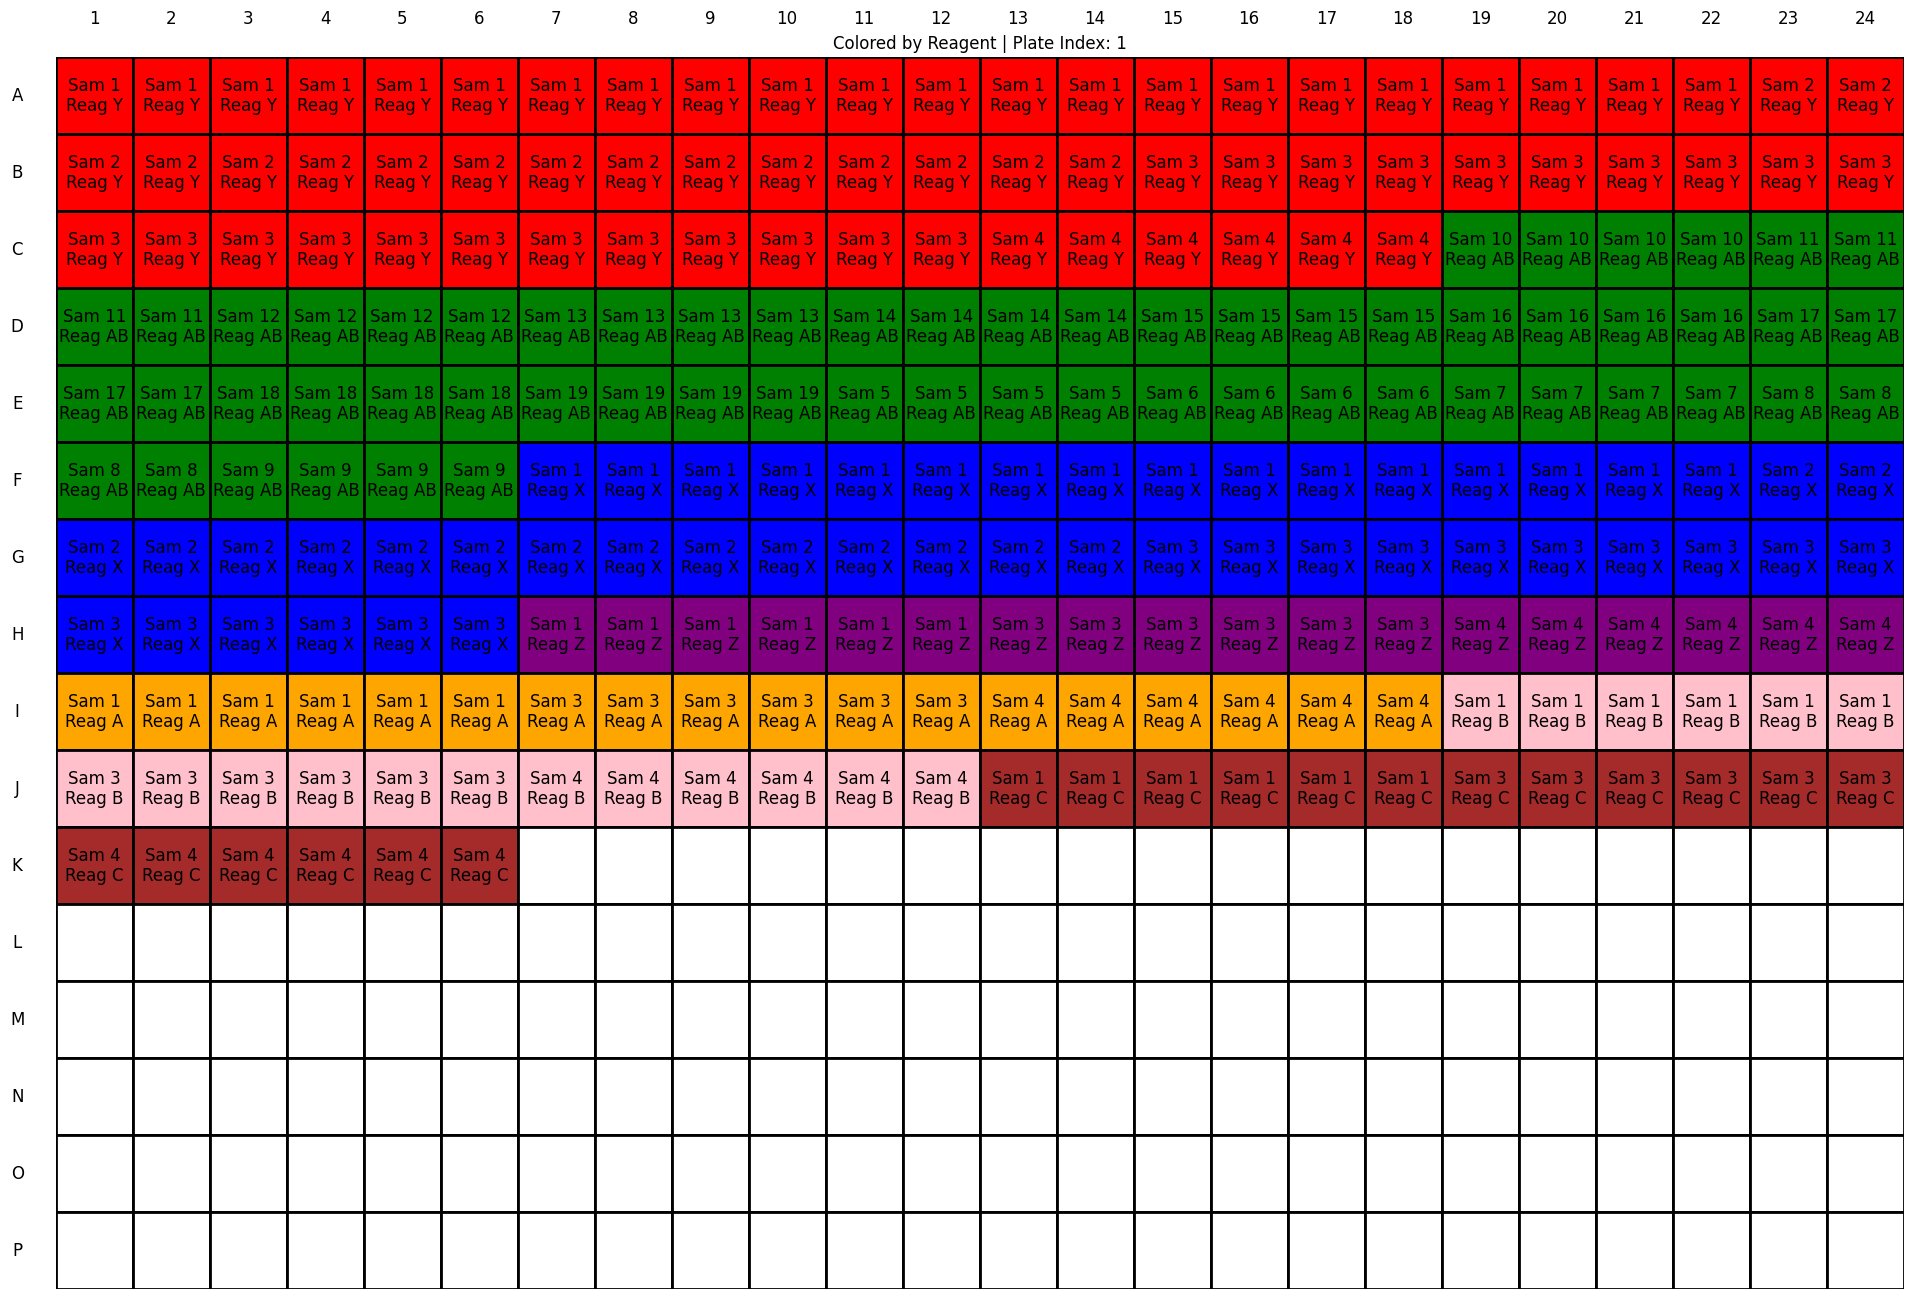

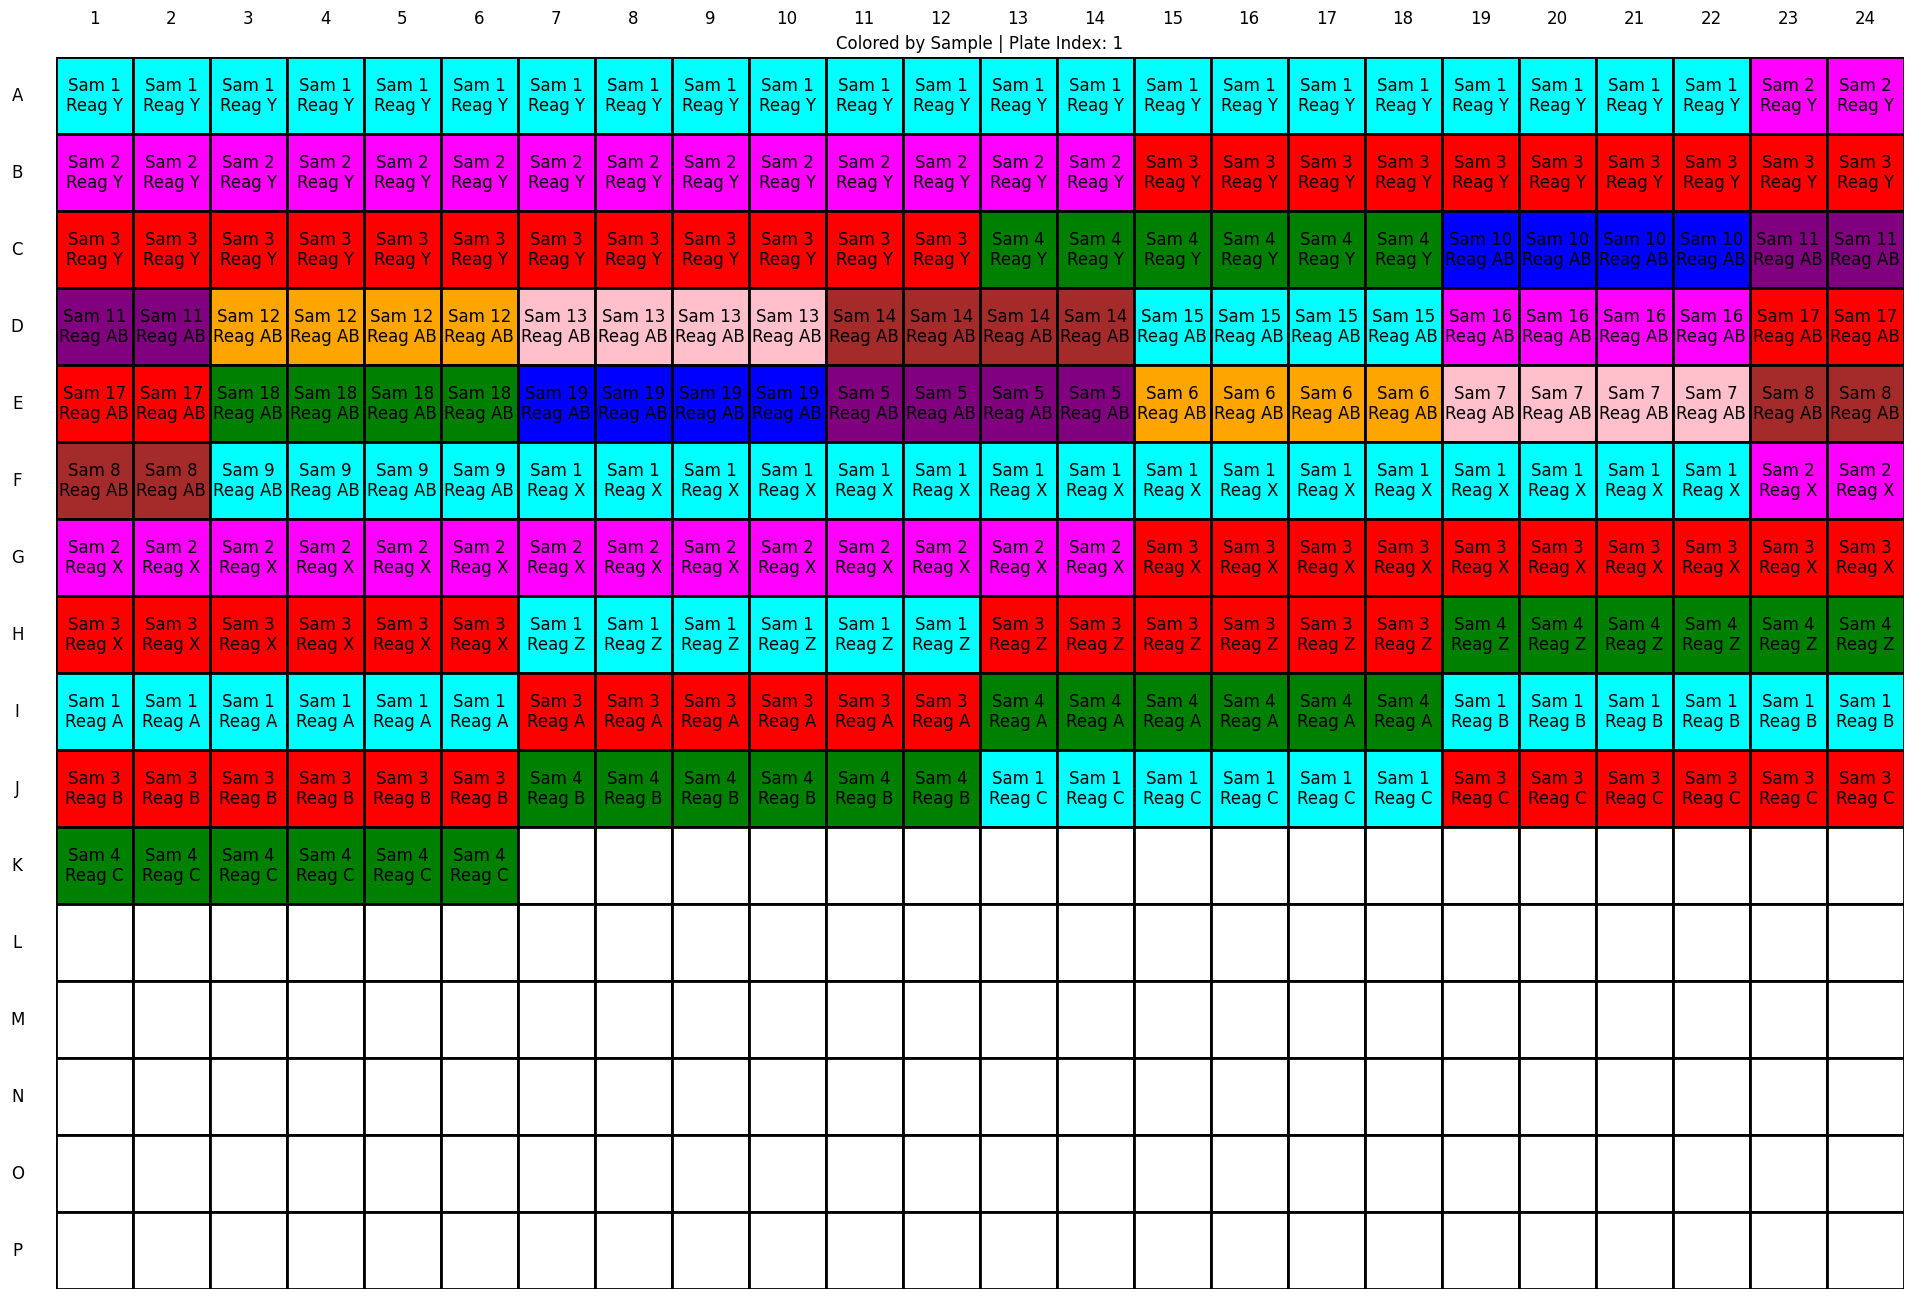

In [24]:
def sort_by_smaller_group_and_fill(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[List[List[str]]]:
    def create_empty_plate(rows, cols):
        return [[[None] for _ in range(cols)] for _ in range(rows)]

    def fill_plate(plate, items, rows, cols):
        current_well = 0
        plates = []
        for sample, reagent in items:
            if current_well == plate_size:
                plates.append(plate)
                plate = create_empty_plate(rows, cols)
                current_well = 0

            row_index = current_well // cols
            col_index = current_well % cols

            plate[row_index][col_index] = [sample, reagent]

            current_well += 1

        if plate:
            plates.append(plate)

        return plates

    enough, wells_needed, wells_available = check_if_enough_plates(plate_size, samples, reagents, replicas, well_num)
    if not enough:
        error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
        raise PlateFillError(error_message)

    if plate_size == 96:
        num_rows = 8
        num_cols = 12
    elif plate_size == 384:
        num_rows = 16
        num_cols = 24

    sample_per_reagent_counter = defaultdict(Counter)
    reagent_per_sample_counter = defaultdict(Counter)
    reagent_counter = Counter()
    sample_counter = Counter()

    for exp_samples, exp_reagents, exp_replicas in zip(samples, reagents, replicas):
        for reagent in exp_reagents:
            for sample in exp_samples:
                sample_per_reagent_counter[reagent][sample] += exp_replicas
                reagent_per_sample_counter[sample][reagent] += exp_replicas
                sample_counter[sample] += exp_replicas
                reagent_counter[reagent] += exp_replicas

    reagents_sorted_by_frequency = [key for key, _ in reagent_counter.most_common()]

    plate = create_empty_plate(num_rows, num_cols)

    items_by_reagent = [(sample, reagent) for reagent in reagents_sorted_by_frequency for sample, freq in sorted(sample_per_reagent_counter[reagent].most_common()) for _ in range(freq)]
    group_by_reagent_result = fill_plate(plate, items_by_reagent, num_rows, num_cols)

    plate = create_empty_plate(num_rows, num_cols)
    items_by_sample = [(sample, reagent) for sample in sample_counter for reagent, freq in sorted(reagent_per_sample_counter[sample].most_common()) for _ in range(freq)]
    group_by_sample_result = fill_plate(plate, items_by_sample, num_rows, num_cols)

    return group_by_reagent_result if evaluate_microplate(group_by_sample_result) >= evaluate_microplate(group_by_reagent_result) else group_by_sample_result

try:
    plates = sort_by_smaller_group_and_fill(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}

for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='reagent', plate_index=i)
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='sample', plate_index=i)


In [ ]:
class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

class PlateFiller:
    def __init__(self, plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int):
        self.plate_size = plate_size
        self.samples = samples
        self.reagents = reagents
        self.replicas = replicas
        self.well_num = well_num
        self.check_if_enough_plates()

    def check_if_enough_plates(self):
        wells_available = plate_size * well_num
        wells_needed = 0
        experiment_count = len(replicas)
        for experiment_number in range(experiment_count):
            wells_needed += len(samples[experiment_number]) * len(reagents[experiment_number]) * replicas[experiment_number]
        
        if wells_needed > wells_available:
            return [0, wells_needed, wells_available]
        else:
            return [1, wells_needed, wells_available]
    
    def evaluate_microplate(self):
        penalty = 0
        for plate in plates:
            previous_sample, previous_reagent = plate[0][0]
            for row in plate:
                for well in row:
                    if any(well):
                        current_sample, current_reagent = well
                        if current_sample != previous_sample:
                            penalty += 1
                            previous_sample = current_sample
                        if current_reagent != previous_reagent:
                            penalty += 1.5
                            previous_reagent = current_reagent
        return penalty
    
    def create_empty_plate(self, rows, cols):
        return [[[None] for _ in range(cols)] for _ in range(rows)]

    def fill_plate(self, plate, items, rows, cols):
        current_well = 0
        plates = []
        for sample, reagent in items:
            if current_well == self.plate_size:
                plates.append(plate)
                plate = self.create_empty_plate(rows, cols)
                current_well = 0

            row_index = current_well // cols
            col_index = current_well % cols

            plate[row_index][col_index] = [sample, reagent]

            current_well += 1

        if plate:
            plates.append(plate)

        return plates

    def sort_by_smaller_group_and_fill(self):
        if self.plate_size == 96:
            num_rows = 8
            num_cols = 12
        elif self.plate_size == 384:
            num_rows = 16
            num_cols = 24

        sample_per_reagent_counter = defaultdict(Counter)
        reagent_per_sample_counter = defaultdict(Counter)
        reagent_counter = Counter()
        sample_counter = Counter()

        for exp_samples, exp_reagents, exp_replicas in zip(self.samples, self.reagents, self.replicas):
            for reagent in exp_reagents:
                for sample in exp_samples:
                    sample_per_reagent_counter[reagent][sample] += exp_replicas
                    reagent_per_sample_counter[sample][reagent] += exp_replicas
                    sample_counter[sample] += exp_replicas
                    reagent_counter[reagent] += exp_replicas

        reagents_sorted_by_frequency = [key for key, _ in reagent_counter.most_common()]
        plate = self.create_empty_plate(num_rows, num_cols)

        items_by_reagent = [(sample, reagent) for reagent in reagents_sorted_by_frequency for sample, freq in sorted(sample_per_reagent_counter[reagent].most_common()) for _ in range(freq)]
        group_by_reagent_result = self.fill_plate(plate, items_by_reagent, num_rows, num_cols)

        plate = self.create_empty_plate(num_rows, num_cols)
        items_by_sample = [(sample, reagent) for sample in sample_counter for reagent, freq in sorted(reagent_per_sample_counter[sample].most_common()) for _ in range(freq)]
        group_by_sample_result = self.fill_plate(plate, items_by_sample, num_rows, num_cols)

        return group_by_reagent_result if self.evaluate_microplate(group_by_sample_result) >= self.evaluate_microplate(group_by_reagent_result) else group_by_sample_result